In [1]:
print("Hello world!")

Hello world!


In [2]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, make_scorer, recall_score
from imblearn.over_sampling import ADASYN
from xgboost import XGBClassifier
from tabulate import tabulate

In [3]:
X_nt = pd.read_csv("C:\Aniruddh\Python\Jupyter\RCC\CSV FILES\Cleaned data\RCC_non_test_set.csv", index_col = 0)
X_t = pd.read_csv("C:\Aniruddh\Python\Jupyter\RCC\CSV FILES\Cleaned data\RCC_test_set.csv", index_col = 0)
X = pd.concat([X_nt, X_t])
y = X.pop("RECURRENCE")
y_nt = X_nt.pop("RECURRENCE")
y_t = X_t.pop("RECURRENCE")

In [4]:
imputer = SimpleImputer(strategy = 'constant', fill_value = 0)
scaler = StandardScaler()
X_nt_sc_i = scaler.fit_transform(imputer.fit_transform(X_nt))
X_t_sc_i = scaler.transform(imputer.transform(X_t))

In [5]:
adasyn = ADASYN(random_state = 42)
X_nt_adasyn, y_nt_adasyn = adasyn.fit_resample(X_nt_sc_i, y_nt)

In [6]:
X_nt_sc_i.shape, X_nt_adasyn.shape, y_nt.shape, y_nt_adasyn.shape

((485, 27), (844, 27), (485,), (844,))

In [7]:
y_nt_adasyn.sum()

420

In [8]:
def grid_searcher(param_grid, estimator, scoring, X_train = X_nt_adasyn, y_train = y_nt_adasyn, cv = 10, verbose = 1):
    tic = time.time()
    grid_search = GridSearchCV(estimator = estimator, param_grid = param_grid, cv = cv, scoring = scoring, n_jobs = -1, verbose = verbose)
    grid_search.fit(X_train, y_train)
    toc = time.time()
    print(f"Time taken: {toc - tic} seconds")
    best_params = grid_search.best_params_
    print(f"Best Hyperparameters: {best_params}")
    best_model = grid_search.best_estimator_
    return best_params, best_model

In [9]:
def model_test(best_estimator, X_test = X_t_sc_i, y_test = y_t, suppress_output = False):
    y_pred_test = best_estimator.predict(X_test)
    class_names = ['Class 0', 'Class 1']
    report_test = classification_report(y_test, y_pred_test, target_names = class_names)
    cm = confusion_matrix(y_test, y_pred_test)
    if not(suppress_output):
        print("Classification Report on Test Set:")
        print(report_test)
        cm_table = tabulate(cm, headers=class_names, tablefmt='grid')
        print("Confusion Matrix:")
        print(cm_table)
        plt.figure(figsize = (8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=class_names, yticklabels=class_names)
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title('Confusion Matrix')
        plt.show()

In [10]:
model1 = XGBClassifier(random_state = 42)

In [11]:
model1.fit(X_nt_adasyn, y_nt_adasyn)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.89      0.96      0.92       183
     Class 1       0.38      0.19      0.26        26

    accuracy                           0.86       209
   macro avg       0.64      0.57      0.59       209
weighted avg       0.83      0.86      0.84       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       175 |         8 |
+-----------+-----------+
|        21 |         5 |
+-----------+-----------+


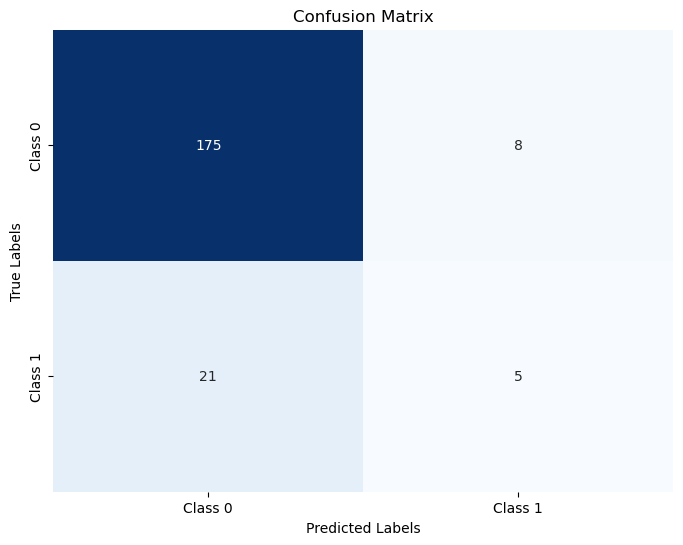

In [13]:
model_test(model1)

# RECALL

Fitting 10 folds for each of 620 candidates, totalling 6200 fits
Time taken: 176.07724165916443 seconds
Best Hyperparameters: {'max_depth': 3, 'n_estimators': 140, 'reg_lambda': 1}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.90      0.97      0.93       183
     Class 1       0.54      0.27      0.36        26

    accuracy                           0.88       209
   macro avg       0.72      0.62      0.65       209
weighted avg       0.86      0.88      0.86       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       177 |         6 |
+-----------+-----------+
|        19 |         7 |
+-----------+-----------+


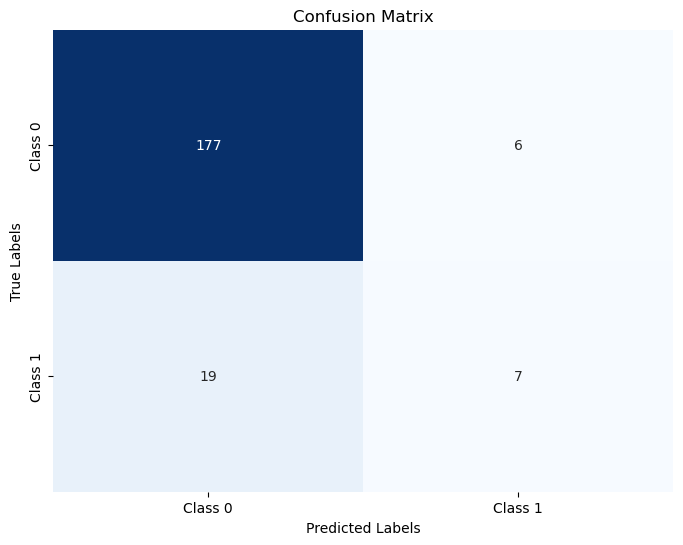

In [15]:
param_grid1a = {
    'n_estimators': list(np.arange(100, 401, 10)),
    'max_depth': [3, 4, 5, 6, 7],
    'reg_lambda': [0.1, 1, 10, 100],
}
best_params1a, best_model1a = grid_searcher(param_grid1a, model1, 'recall')
model_test(best_model1a)

Fitting 10 folds for each of 600 candidates, totalling 6000 fits
Time taken: 65.03862500190735 seconds
Best Hyperparameters: {'learning_rate': 0.1, 'reg_lambda': 0.2}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.93      0.95      0.94       183
     Class 1       0.57      0.46      0.51        26

    accuracy                           0.89       209
   macro avg       0.75      0.71      0.72       209
weighted avg       0.88      0.89      0.88       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       174 |         9 |
+-----------+-----------+
|        14 |        12 |
+-----------+-----------+


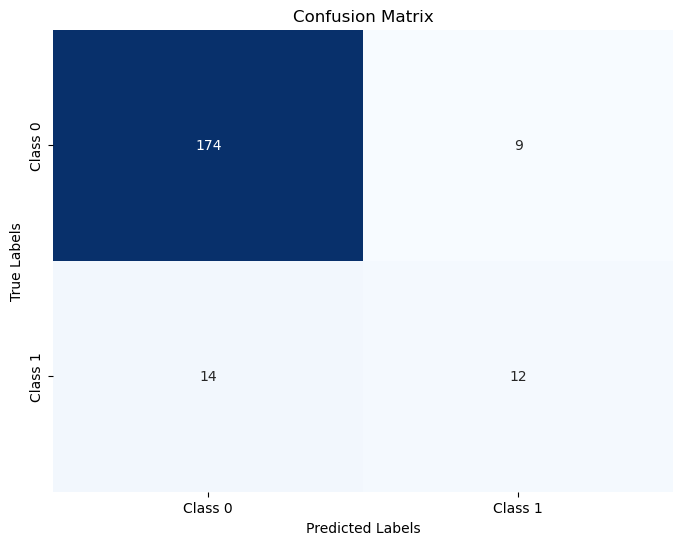

In [16]:
param_grid1b = {
    'reg_lambda': list(np.arange(0.1, 10.1, 0.1)),
    'learning_rate': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]
}
best_params1b, best_model1b = grid_searcher(param_grid1b, best_model1a, 'recall')
model_test(best_model1b)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Time taken: 12.07047414779663 seconds
Best Hyperparameters: {'learning_rate': 0.09999999999999999}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.93      0.95      0.94       183
     Class 1       0.57      0.46      0.51        26

    accuracy                           0.89       209
   macro avg       0.75      0.71      0.72       209
weighted avg       0.88      0.89      0.88       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       174 |         9 |
+-----------+-----------+
|        14 |        12 |
+-----------+-----------+


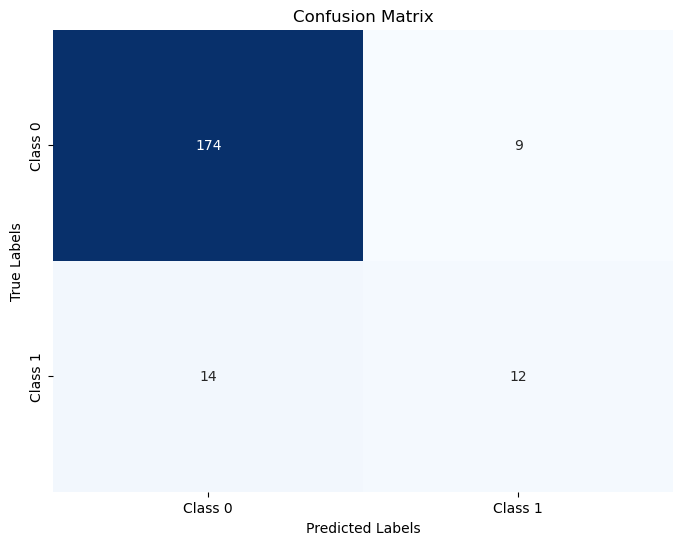

In [17]:
param_grid1c = {
    'learning_rate': list(np.arange(1e-2, 1.01, 1e-2))
}
best_params1c, best_model1c = grid_searcher(param_grid1c, best_model1b, 'recall')
model_test(best_model1c)

Fitting 10 folds for each of 180 candidates, totalling 1800 fits
Time taken: 25.699560165405273 seconds
Best Hyperparameters: {'colsample_bytree': 0.8, 'min_child_weight': 1, 'subsample': 0.9}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.91      0.94      0.93       183
     Class 1       0.48      0.38      0.43        26

    accuracy                           0.87       209
   macro avg       0.70      0.66      0.68       209
weighted avg       0.86      0.87      0.86       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       172 |        11 |
+-----------+-----------+
|        16 |        10 |
+-----------+-----------+


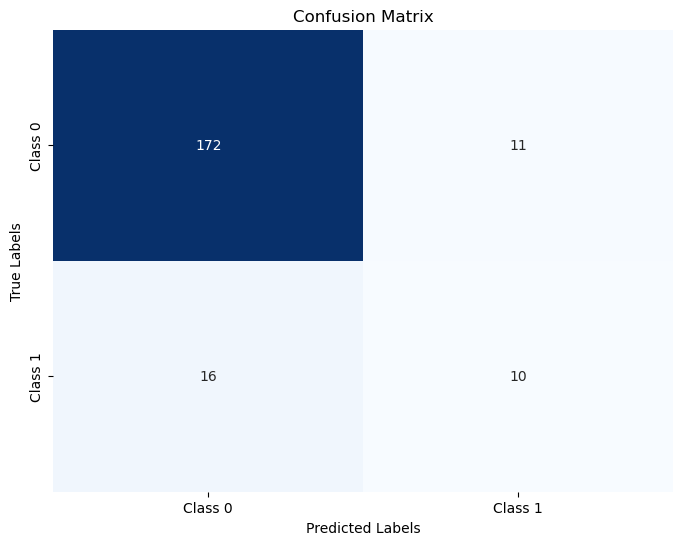

In [18]:
param_grid1d = {
    'min_child_weight': [1, 2, 3, 4, 5],
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
}
best_params1d, best_model1d = grid_searcher(param_grid1d, best_model1c, 'recall')
model_test(best_model1d)

Fitting 10 folds for each of 15 candidates, totalling 150 fits
Time taken: 2.0947608947753906 seconds
Best Hyperparameters: {'gamma': 0, 'max_delta_step': 0}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.91      0.94      0.93       183
     Class 1       0.48      0.38      0.43        26

    accuracy                           0.87       209
   macro avg       0.70      0.66      0.68       209
weighted avg       0.86      0.87      0.86       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       172 |        11 |
+-----------+-----------+
|        16 |        10 |
+-----------+-----------+


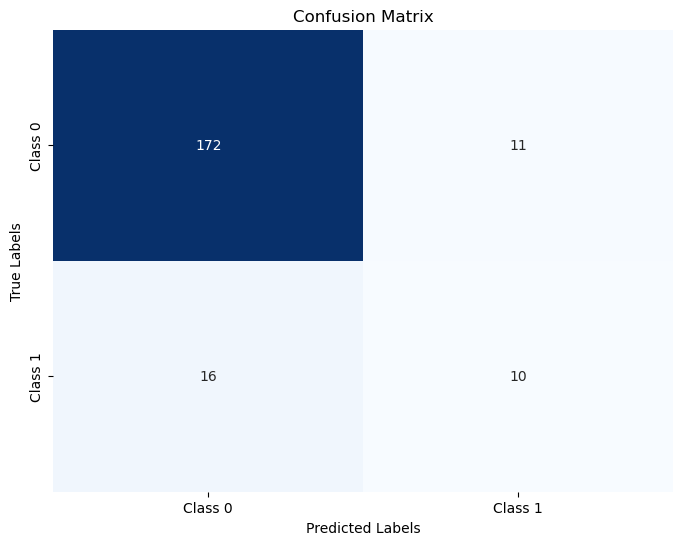

In [20]:
param_grid1e = {
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    # 'reg_alpha': [0.1, 1, 10, 100],
    # 'scale_pos_weight': [1, 2, 3, 4, 5],
    'max_delta_step': [0, 1, 2],
}
best_params1e, best_model1e = grid_searcher(param_grid1e, best_model1d, 'recall')
model_test(best_model1e)

# PRECISION

Fitting 10 folds for each of 620 candidates, totalling 6200 fits
Time taken: 181.1224663257599 seconds
Best Hyperparameters: {'max_depth': 5, 'n_estimators': 310, 'reg_lambda': 0.1}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.90      0.96      0.93       183
     Class 1       0.46      0.23      0.31        26

    accuracy                           0.87       209
   macro avg       0.68      0.60      0.62       209
weighted avg       0.84      0.87      0.85       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       176 |         7 |
+-----------+-----------+
|        20 |         6 |
+-----------+-----------+


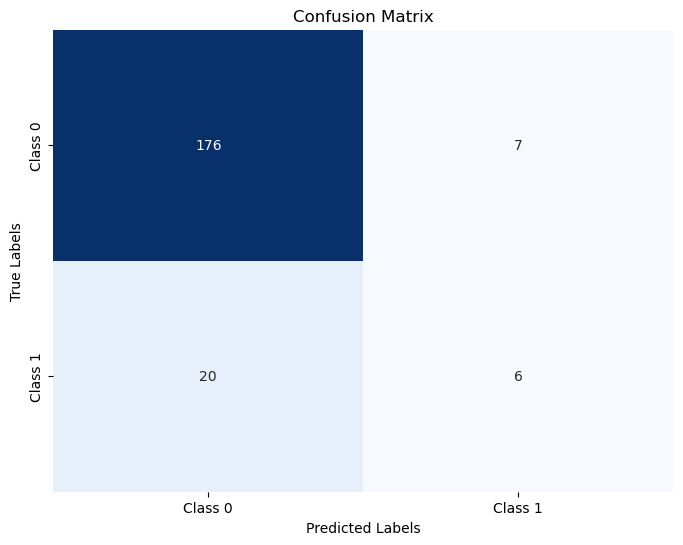

In [21]:
param_grid2a = {
    'n_estimators': list(np.arange(100, 401, 10)),
    'max_depth': [3, 4, 5, 6, 7],
    'reg_lambda': [0.1, 1, 10, 100],
}
best_params2a, best_model2a = grid_searcher(param_grid2a, model1, 'precision')
model_test(best_model2a)

Fitting 10 folds for each of 600 candidates, totalling 6000 fits
Time taken: 268.1732223033905 seconds
Best Hyperparameters: {'learning_rate': 1, 'reg_lambda': 8.1}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.90      0.95      0.92       183
     Class 1       0.40      0.23      0.29        26

    accuracy                           0.86       209
   macro avg       0.65      0.59      0.61       209
weighted avg       0.84      0.86      0.84       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       174 |         9 |
+-----------+-----------+
|        20 |         6 |
+-----------+-----------+


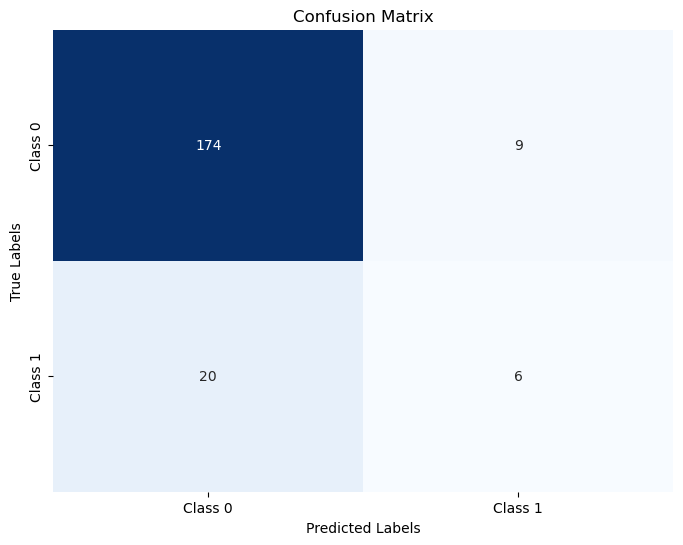

In [23]:
param_grid2b = {
    'reg_lambda': list(np.arange(0.1, 10.1, 0.1)),
    'learning_rate': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]
}
best_params2b, best_model2b = grid_searcher(param_grid2b, best_model2a, 'precision')
model_test(best_model2b)

Fitting 10 folds for each of 99 candidates, totalling 990 fits
Time taken: 35.82084798812866 seconds
Best Hyperparameters: {'learning_rate': 0.92}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.90      0.95      0.93       183
     Class 1       0.44      0.27      0.33        26

    accuracy                           0.87       209
   macro avg       0.67      0.61      0.63       209
weighted avg       0.84      0.87      0.85       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       174 |         9 |
+-----------+-----------+
|        19 |         7 |
+-----------+-----------+


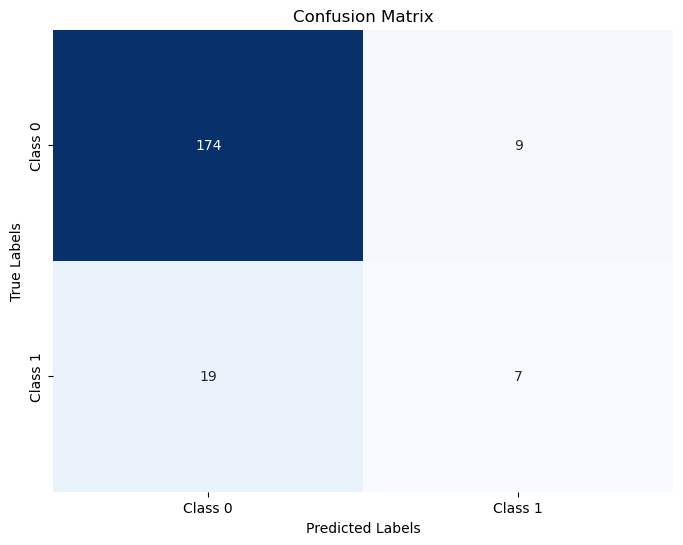

In [24]:
param_grid2c = {
    'learning_rate': list(np.arange(0.01, 1, 0.01))
}
best_params2c, best_model2c = grid_searcher(param_grid2c, best_model2b, 'precision')
model_test(best_model2c)

Fitting 10 folds for each of 108 candidates, totalling 1080 fits
Time taken: 24.35658073425293 seconds
Best Hyperparameters: {'colsample_bytree': 1.0, 'min_child_weight': 1, 'subsample': 1.0}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.90      0.95      0.93       183
     Class 1       0.44      0.27      0.33        26

    accuracy                           0.87       209
   macro avg       0.67      0.61      0.63       209
weighted avg       0.84      0.87      0.85       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       174 |         9 |
+-----------+-----------+
|        19 |         7 |
+-----------+-----------+


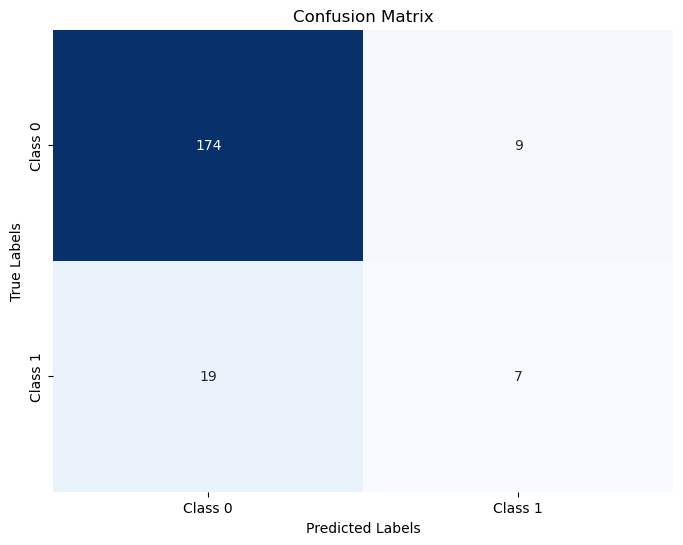

In [25]:
param_grid2d = {
    'min_child_weight': [1, 2, 3],
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
}
best_params2d, best_model2d = grid_searcher(param_grid2d, best_model2c, 'precision')
model_test(best_model2d)

Fitting 10 folds for each of 375 candidates, totalling 3750 fits
Time taken: 50.574371337890625 seconds
Best Hyperparameters: {'gamma': 0, 'max_delta_step': 2, 'reg_alpha': 0.1, 'scale_pos_weight': 1}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.90      0.97      0.93       183
     Class 1       0.54      0.27      0.36        26

    accuracy                           0.88       209
   macro avg       0.72      0.62      0.65       209
weighted avg       0.86      0.88      0.86       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       177 |         6 |
+-----------+-----------+
|        19 |         7 |
+-----------+-----------+


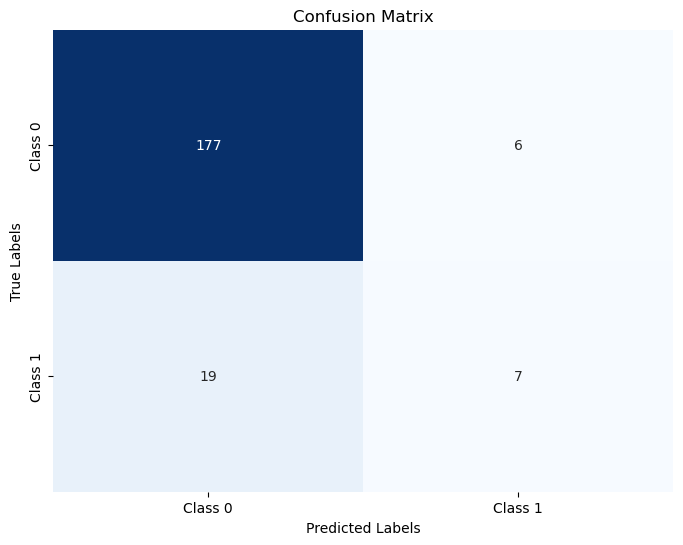

In [26]:
param_grid2e = {
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'reg_alpha': [0.01, 0.1, 1, 10, 100],
    'scale_pos_weight': [1, 2, 3, 4, 5],
    'max_delta_step': [0, 1, 2],
}
best_params2e, best_model2e = grid_searcher(param_grid2e, best_model2d, 'precision')
model_test(best_model2e)

# F1

Fitting 10 folds for each of 620 candidates, totalling 6200 fits
Time taken: 126.21174383163452 seconds
Best Hyperparameters: {'max_depth': 7, 'n_estimators': 310, 'reg_lambda': 1}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.89      0.96      0.92       183
     Class 1       0.38      0.19      0.26        26

    accuracy                           0.86       209
   macro avg       0.64      0.57      0.59       209
weighted avg       0.83      0.86      0.84       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       175 |         8 |
+-----------+-----------+
|        21 |         5 |
+-----------+-----------+


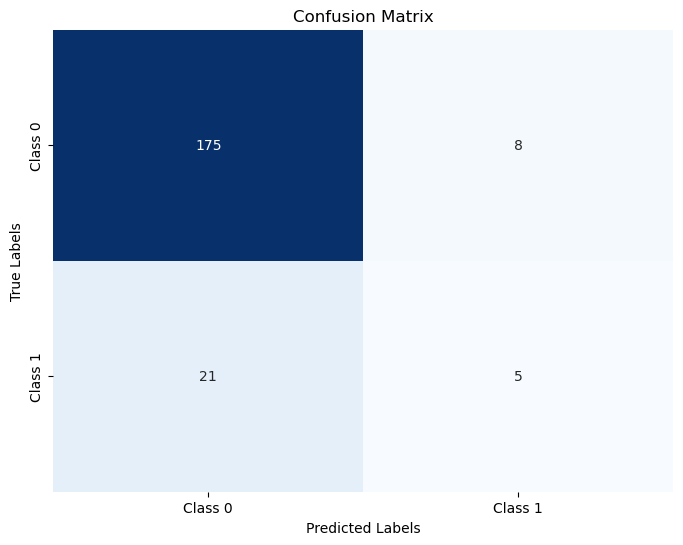

In [27]:
param_grid3a = {
    'n_estimators': list(np.arange(100, 401, 10)),
    'max_depth': [3, 4, 5, 6, 7],
    'reg_lambda': [0.1, 1, 10, 100],
}
best_params3a, best_model3a = grid_searcher(param_grid3a, model1, 'f1')
model_test(best_model3a)

Fitting 10 folds for each of 5 candidates, totalling 50 fits
Time taken: 1.313417911529541 seconds
Best Hyperparameters: {'max_depth': 7}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.89      0.96      0.92       183
     Class 1       0.38      0.19      0.26        26

    accuracy                           0.86       209
   macro avg       0.64      0.57      0.59       209
weighted avg       0.83      0.86      0.84       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       175 |         8 |
+-----------+-----------+
|        21 |         5 |
+-----------+-----------+


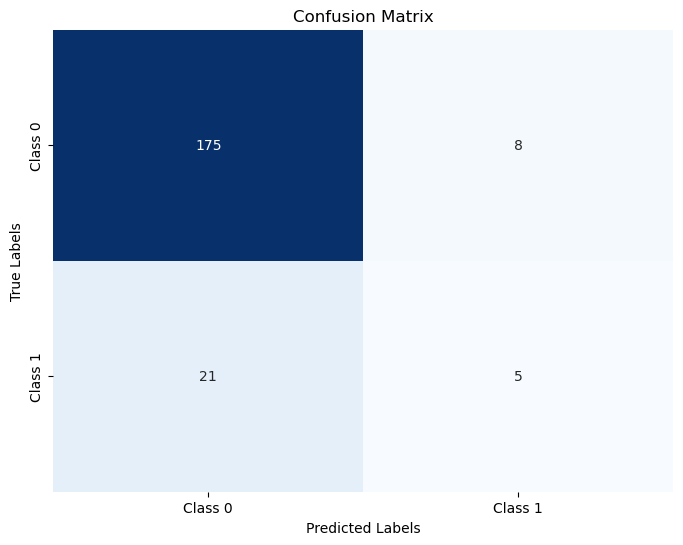

In [28]:
param_grid3ai = {
    'max_depth': [5, 6, 7, 8, 9],
}
best_params3ai, best_model3ai = grid_searcher(param_grid3ai, best_model3a, 'f1')
model_test(best_model3ai)

Fitting 10 folds for each of 594 candidates, totalling 5940 fits
Time taken: 265.7180006504059 seconds
Best Hyperparameters: {'learning_rate': 1, 'reg_lambda': 5.9}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.90      0.92      0.91       183
     Class 1       0.33      0.27      0.30        26

    accuracy                           0.84       209
   macro avg       0.62      0.60      0.60       209
weighted avg       0.83      0.84      0.83       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       169 |        14 |
+-----------+-----------+
|        19 |         7 |
+-----------+-----------+


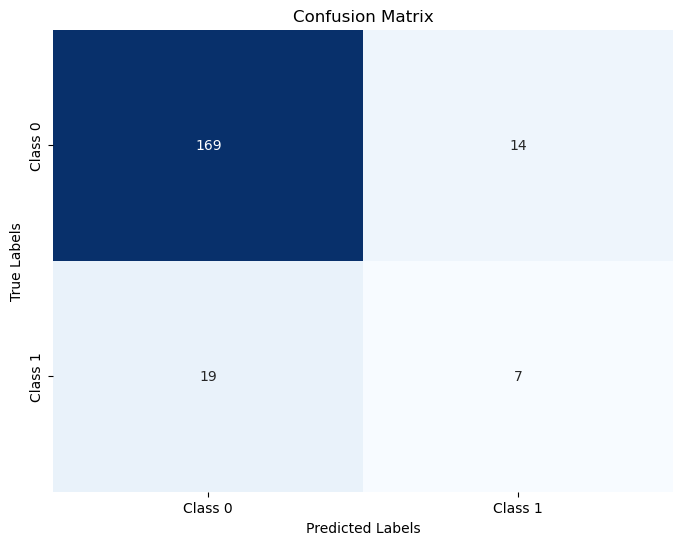

In [29]:
param_grid3b = {
    'reg_lambda': list(np.arange(0.1, 10, 0.1)),
    'learning_rate': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]
}
best_params3b, best_model3b = grid_searcher(param_grid3b, best_model3a, 'f1')
model_test(best_model3b)

Fitting 10 folds for each of 99 candidates, totalling 990 fits
Time taken: 27.744161367416382 seconds
Best Hyperparameters: {'learning_rate': 0.66}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.89      0.93      0.91       183
     Class 1       0.32      0.23      0.27        26

    accuracy                           0.84       209
   macro avg       0.61      0.58      0.59       209
weighted avg       0.82      0.84      0.83       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       170 |        13 |
+-----------+-----------+
|        20 |         6 |
+-----------+-----------+


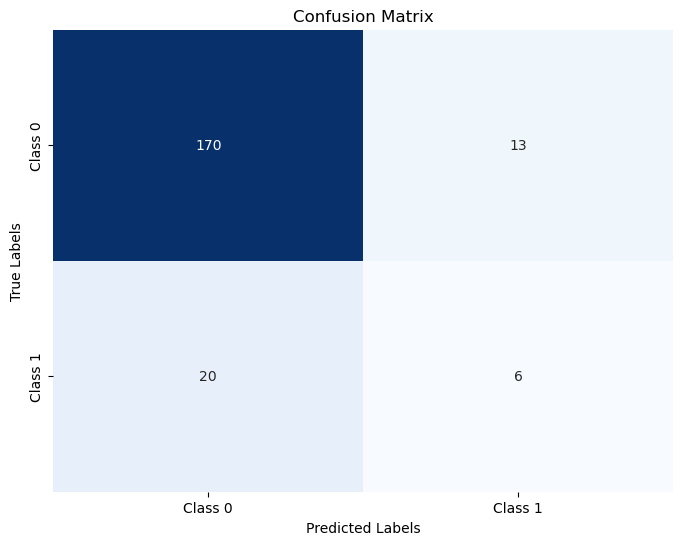

In [30]:
param_grid3c = {
    'learning_rate': list(np.arange(0.01, 1, 0.01)),
}
best_params3c, best_model3c = grid_searcher(param_grid3c, best_model3b, 'f1')
model_test(best_model3c)

Fitting 10 folds for each of 108 candidates, totalling 1080 fits
Time taken: 16.03919005393982 seconds
Best Hyperparameters: {'colsample_bytree': 0.9, 'min_child_weight': 2, 'subsample': 0.8}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.91      0.96      0.93       183
     Class 1       0.53      0.35      0.42        26

    accuracy                           0.88       209
   macro avg       0.72      0.65      0.68       209
weighted avg       0.86      0.88      0.87       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       175 |         8 |
+-----------+-----------+
|        17 |         9 |
+-----------+-----------+


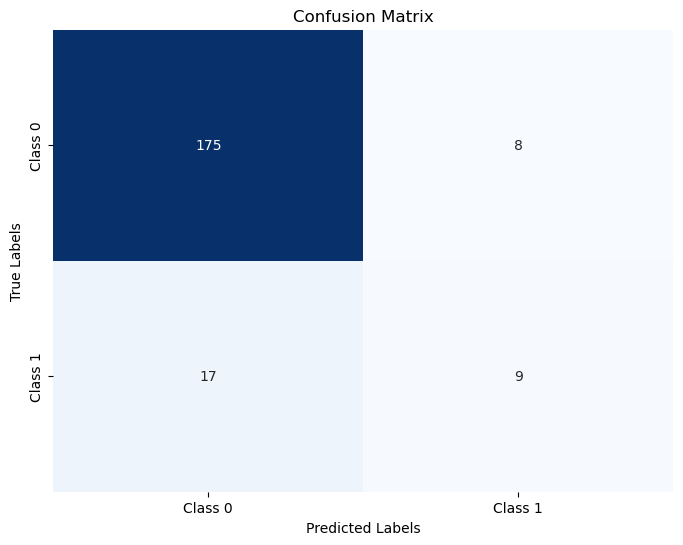

In [31]:
param_grid3d = {
    'min_child_weight': [1, 2, 3],
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
}
best_params3d, best_model3d = grid_searcher(param_grid3d, best_model3c, 'f1')
model_test(best_model3d)

Fitting 10 folds for each of 375 candidates, totalling 3750 fits
Time taken: 39.117799043655396 seconds
Best Hyperparameters: {'gamma': 0.4, 'max_delta_step': 0, 'reg_alpha': 0.1, 'scale_pos_weight': 1}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.90      0.93      0.92       183
     Class 1       0.40      0.31      0.35        26

    accuracy                           0.86       209
   macro avg       0.65      0.62      0.63       209
weighted avg       0.84      0.86      0.85       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       171 |        12 |
+-----------+-----------+
|        18 |         8 |
+-----------+-----------+


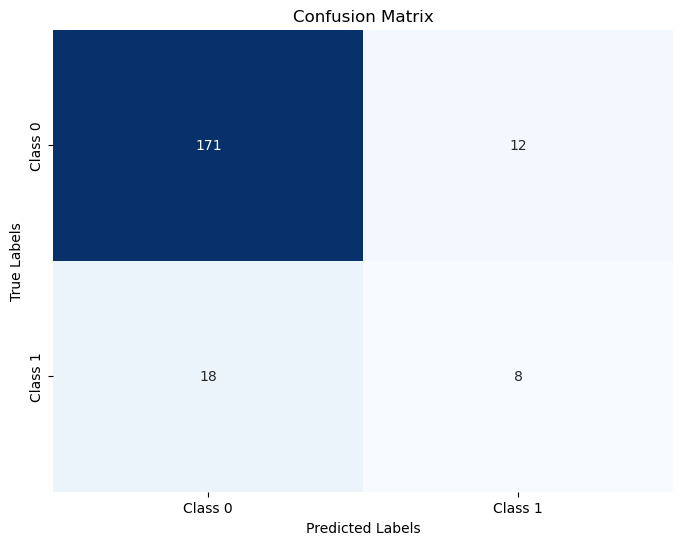

In [32]:
param_grid3e = {
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'reg_alpha': [0.01, 0.1, 1, 10, 100],
    'scale_pos_weight': [1, 2, 3, 4, 5],
    'max_delta_step': [0, 1, 2],
}
best_params3e, best_model3e = grid_searcher(param_grid3e, best_model3d, 'f1')
model_test(best_model3e)

Fitting 10 folds for each of 99 candidates, totalling 990 fits
Time taken: 24.982235193252563 seconds
Best Hyperparameters: {'reg_alpha': 0.04}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.90      0.96      0.93       183
     Class 1       0.43      0.23      0.30        26

    accuracy                           0.87       209
   macro avg       0.66      0.59      0.61       209
weighted avg       0.84      0.87      0.85       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       175 |         8 |
+-----------+-----------+
|        20 |         6 |
+-----------+-----------+


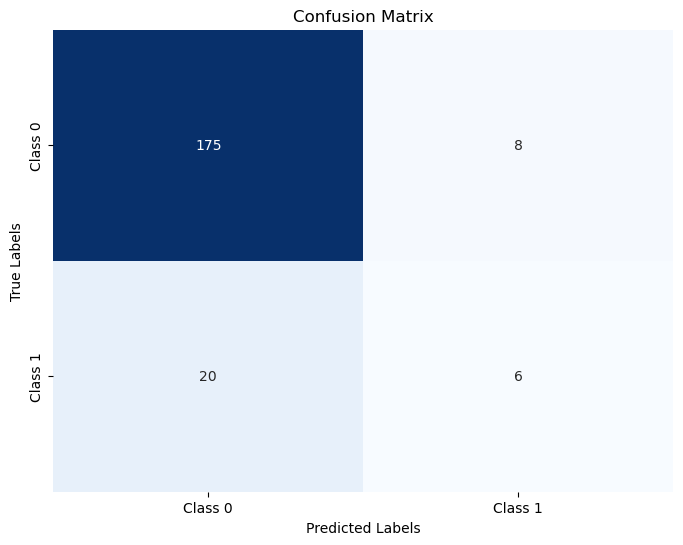

In [33]:
param_grid3f = {
    'reg_alpha': list(np.arange(0.01, 1, 0.01))
}
best_params3f, best_model3f = grid_searcher(param_grid3f, best_model3e, 'f1')
model_test(best_model3f)

# ROC_AUC

Fitting 10 folds for each of 620 candidates, totalling 6200 fits
Time taken: 171.7980010509491 seconds
Best Hyperparameters: {'max_depth': 5, 'n_estimators': 110, 'reg_lambda': 10}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.91      0.94      0.92       183
     Class 1       0.42      0.31      0.36        26

    accuracy                           0.86       209
   macro avg       0.66      0.62      0.64       209
weighted avg       0.85      0.86      0.85       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       172 |        11 |
+-----------+-----------+
|        18 |         8 |
+-----------+-----------+


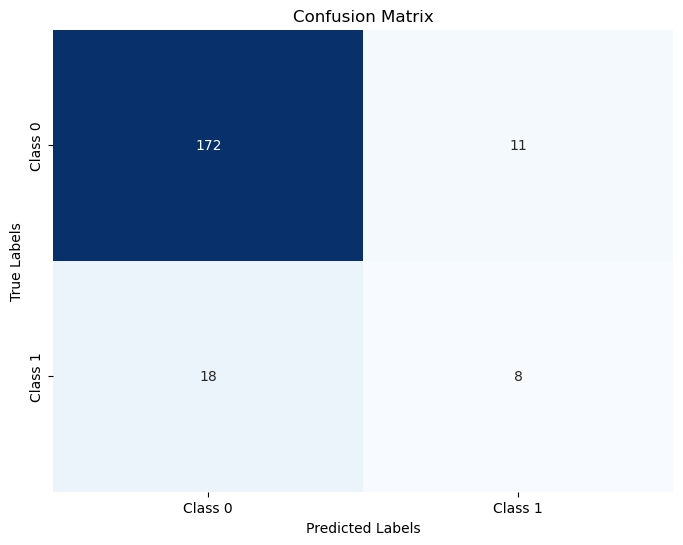

In [34]:
param_grid4a = {
    'n_estimators': list(np.arange(100, 401, 10)),
    'max_depth': [3, 4, 5, 6, 7],
    'reg_lambda': [0.1, 1, 10, 100],
}
best_params4a, best_model4a = grid_searcher(param_grid4a, model1, 'roc_auc')
model_test(best_model4a)

Fitting 10 folds for each of 600 candidates, totalling 6000 fits
Time taken: 104.60305738449097 seconds
Best Hyperparameters: {'learning_rate': 1, 'reg_lambda': 30}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.91      0.95      0.93       183
     Class 1       0.44      0.31      0.36        26

    accuracy                           0.87       209
   macro avg       0.68      0.63      0.64       209
weighted avg       0.85      0.87      0.86       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       173 |        10 |
+-----------+-----------+
|        18 |         8 |
+-----------+-----------+


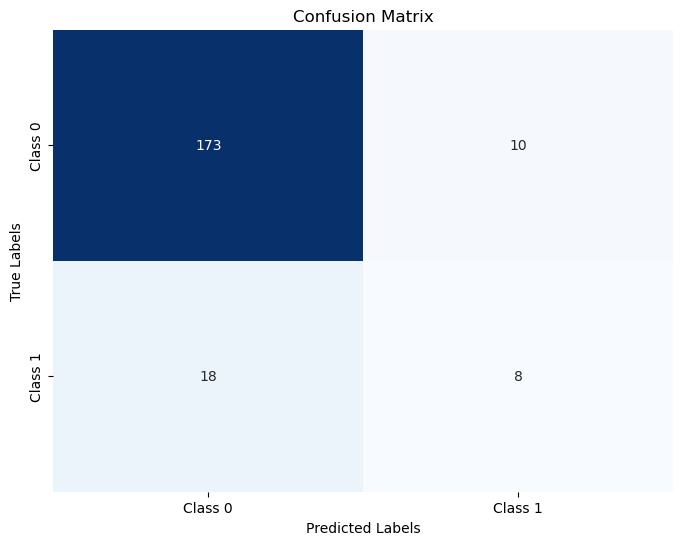

In [35]:
param_grid4b = {
    'reg_lambda': list(np.arange(1, 101)),
    'learning_rate': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]
}
best_params4b, best_model4b = grid_searcher(param_grid4b, best_model4a, 'roc_auc')
model_test(best_model4b)

Fitting 10 folds for each of 99 candidates, totalling 990 fits
Time taken: 17.253821849822998 seconds
Best Hyperparameters: {'learning_rate': 0.67}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.92      0.93      0.93       183
     Class 1       0.48      0.42      0.45        26

    accuracy                           0.87       209
   macro avg       0.70      0.68      0.69       209
weighted avg       0.86      0.87      0.87       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       171 |        12 |
+-----------+-----------+
|        15 |        11 |
+-----------+-----------+


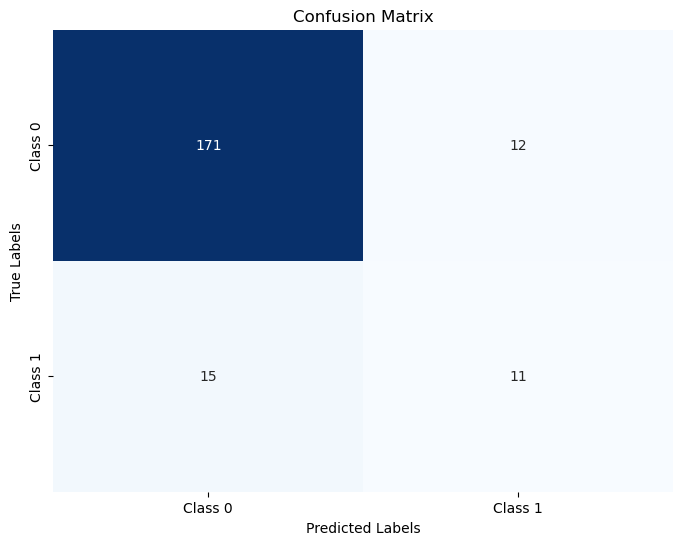

In [36]:
param_grid4c = {
    'learning_rate': list(np.arange(0.01, 1, 0.01))
}
best_params4c, best_model4c = grid_searcher(param_grid4c, best_model4b, 'roc_auc')
model_test(best_model4c)

Fitting 10 folds for each of 108 candidates, totalling 1080 fits
Time taken: 14.091586351394653 seconds
Best Hyperparameters: {'colsample_bytree': 0.7, 'min_child_weight': 1, 'subsample': 0.9}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.91      0.96      0.93       183
     Class 1       0.50      0.31      0.38        26

    accuracy                           0.88       209
   macro avg       0.70      0.63      0.66       209
weighted avg       0.86      0.88      0.86       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       175 |         8 |
+-----------+-----------+
|        18 |         8 |
+-----------+-----------+


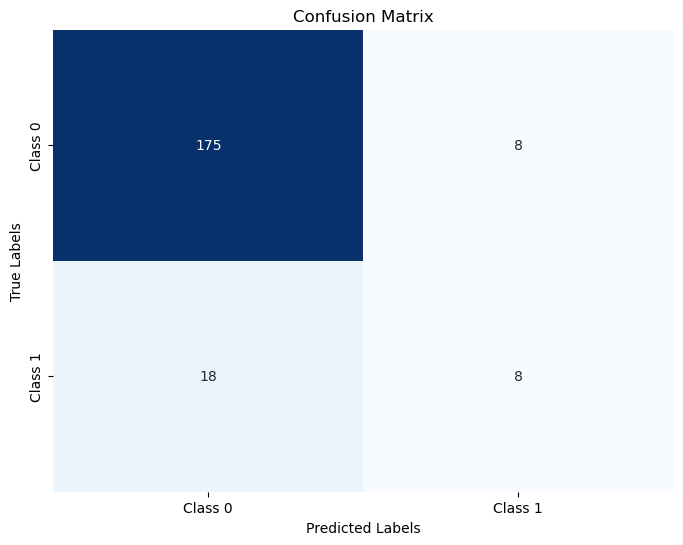

In [37]:
param_grid4d = {
    'min_child_weight': [1, 2, 3],
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
}
best_params4d, best_model4d = grid_searcher(param_grid4d, best_model4c, 'roc_auc')
model_test(best_model4d)

Fitting 10 folds for each of 375 candidates, totalling 3750 fits
Time taken: 35.319700956344604 seconds
Best Hyperparameters: {'gamma': 0, 'max_delta_step': 0, 'reg_alpha': 0.1, 'scale_pos_weight': 5}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.91      0.88      0.90       183
     Class 1       0.33      0.42      0.37        26

    accuracy                           0.82       209
   macro avg       0.62      0.65      0.63       209
weighted avg       0.84      0.82      0.83       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       161 |        22 |
+-----------+-----------+
|        15 |        11 |
+-----------+-----------+


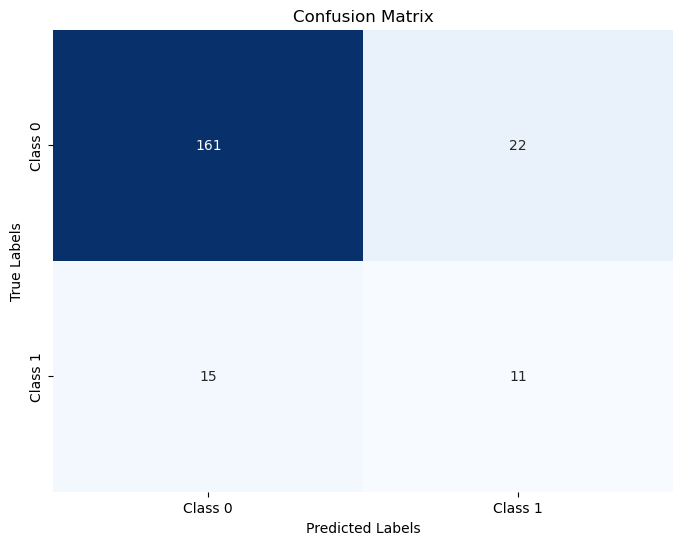

In [38]:
param_grid4e = {
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'reg_alpha': [0.01, 0.1, 1, 10, 100],
    'scale_pos_weight': [1, 2, 3, 4, 5],
    'max_delta_step': [0, 1, 2],
}
best_params4e, best_model4e = grid_searcher(param_grid4e, best_model4d, 'roc_auc')
model_test(best_model4e)

Fitting 10 folds for each of 99 candidates, totalling 990 fits
Time taken: 16.642894744873047 seconds
Best Hyperparameters: {'reg_alpha': 0.17}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.92      0.87      0.90       183
     Class 1       0.36      0.50      0.42        26

    accuracy                           0.83       209
   macro avg       0.64      0.69      0.66       209
weighted avg       0.85      0.83      0.84       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       160 |        23 |
+-----------+-----------+
|        13 |        13 |
+-----------+-----------+


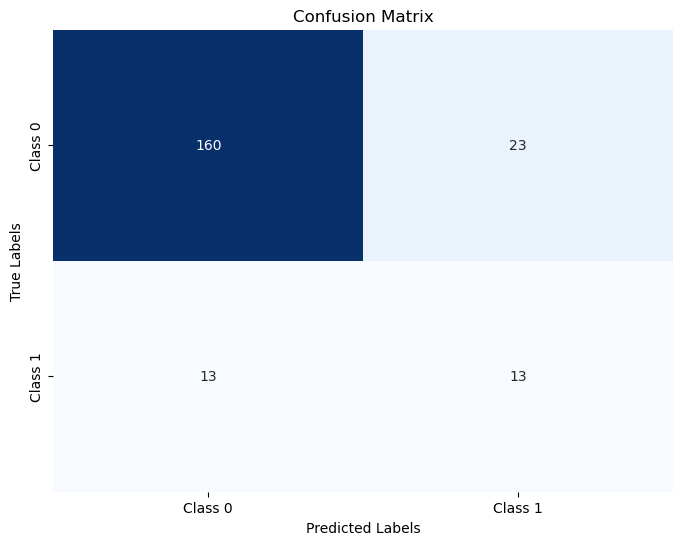

In [39]:
param_grid4f = {
    'reg_alpha': list(np.arange(0.01, 1, 0.01)),
}
best_params4f, best_model4f = grid_searcher(param_grid4f, best_model4e, 'roc_auc')
model_test(best_model4f)

# MATTHEWS_CORRCOEF

Fitting 10 folds for each of 620 candidates, totalling 6200 fits
Time taken: 168.42243790626526 seconds
Best Hyperparameters: {'max_depth': 7, 'n_estimators': 310, 'reg_lambda': 1}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.89      0.96      0.92       183
     Class 1       0.38      0.19      0.26        26

    accuracy                           0.86       209
   macro avg       0.64      0.57      0.59       209
weighted avg       0.83      0.86      0.84       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       175 |         8 |
+-----------+-----------+
|        21 |         5 |
+-----------+-----------+


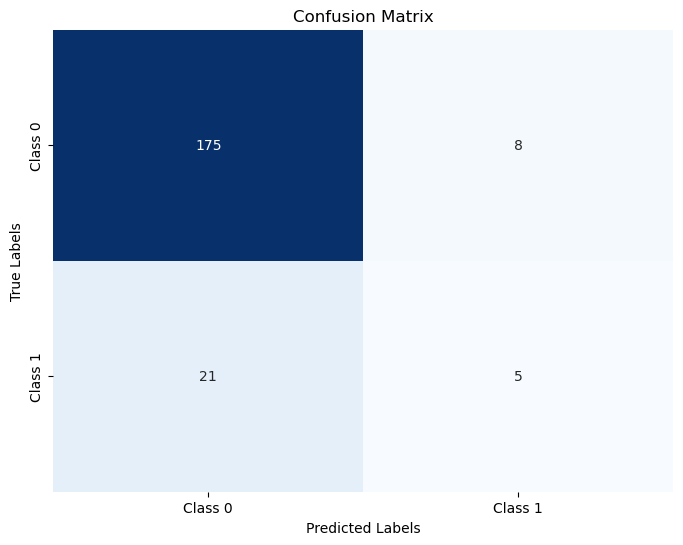

In [40]:
param_grid5a = {
    'n_estimators': list(np.arange(100, 401, 10)),
    'max_depth': [3, 4, 5, 6, 7],
    'reg_lambda': [0.1, 1, 10, 100],
}
best_params5a, best_model5a = grid_searcher(param_grid5a, model1, 'matthews_corrcoef')
model_test(best_model5a)

Fitting 10 folds for each of 5 candidates, totalling 50 fits
Time taken: 2.283460855484009 seconds
Best Hyperparameters: {'max_depth': 7}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.89      0.96      0.92       183
     Class 1       0.38      0.19      0.26        26

    accuracy                           0.86       209
   macro avg       0.64      0.57      0.59       209
weighted avg       0.83      0.86      0.84       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       175 |         8 |
+-----------+-----------+
|        21 |         5 |
+-----------+-----------+


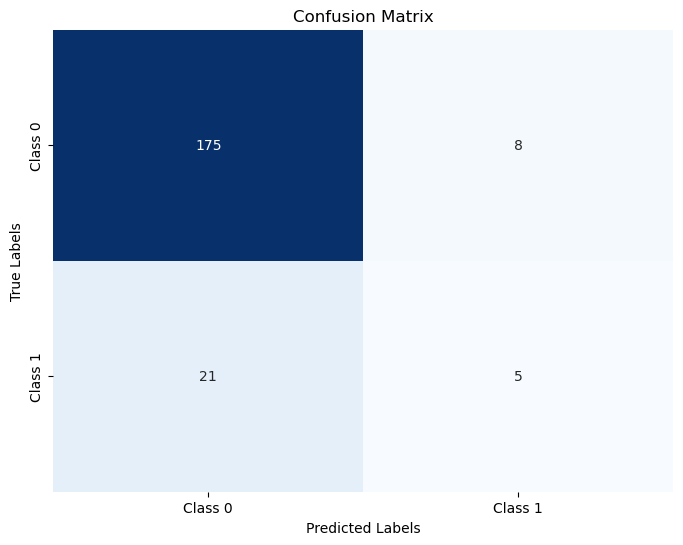

In [41]:
param_grid5ai = {
    'max_depth': [5, 6, 7, 8, 9],
}
best_params5ai, best_model5ai = grid_searcher(param_grid5ai, best_model5a, 'matthews_corrcoef')
model_test(best_model5ai)

Fitting 10 folds for each of 600 candidates, totalling 6000 fits
Time taken: 356.29419803619385 seconds
Best Hyperparameters: {'learning_rate': 1, 'reg_lambda': 1.2000000000000002}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.89      0.95      0.92       183
     Class 1       0.36      0.19      0.25        26

    accuracy                           0.86       209
   macro avg       0.62      0.57      0.59       209
weighted avg       0.83      0.86      0.84       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       174 |         9 |
+-----------+-----------+
|        21 |         5 |
+-----------+-----------+


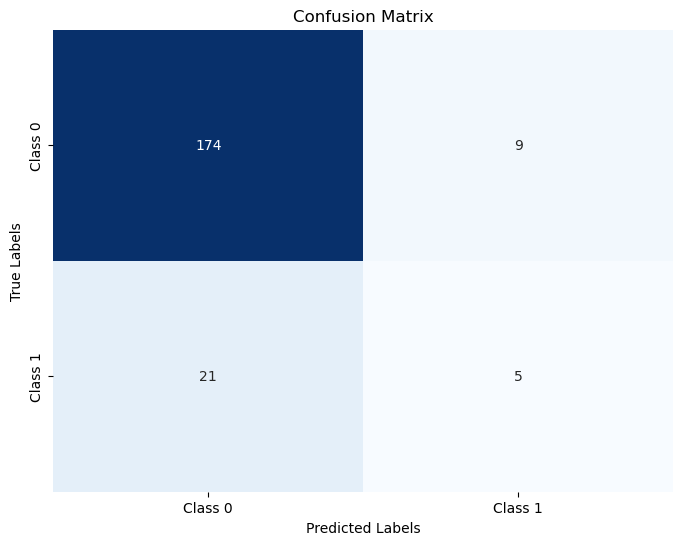

In [42]:
param_grid5b = {
    'reg_lambda': list(np.arange(0.1, 10.1, 0.1)),
    'learning_rate': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]
}
best_params5b, best_model5b = grid_searcher(param_grid5b, best_model5a, 'matthews_corrcoef')
model_test(best_model5b)

Fitting 10 folds for each of 99 candidates, totalling 990 fits
Time taken: 33.02797222137451 seconds
Best Hyperparameters: {'learning_rate': 0.39}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.90      0.96      0.93       183
     Class 1       0.47      0.27      0.34        26

    accuracy                           0.87       209
   macro avg       0.68      0.61      0.63       209
weighted avg       0.85      0.87      0.86       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       175 |         8 |
+-----------+-----------+
|        19 |         7 |
+-----------+-----------+


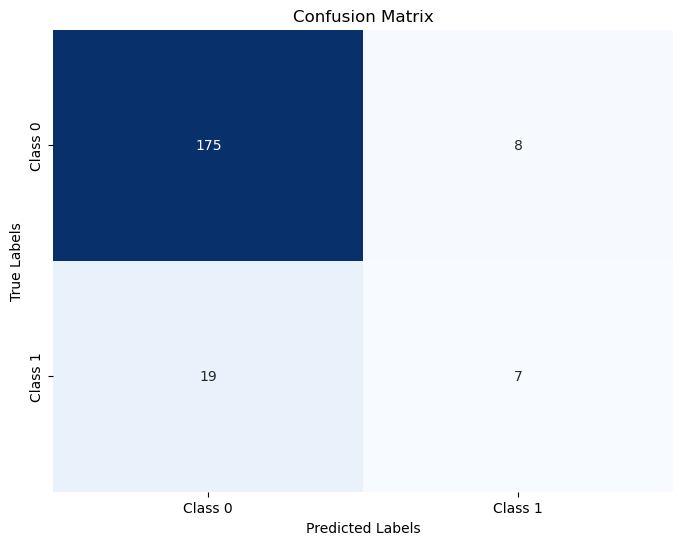

In [43]:
param_grid5c = {
    'learning_rate': list(np.arange(0.01, 1, 0.01))
}
best_params5c, best_model5c = grid_searcher(param_grid5c, best_model5b, 'matthews_corrcoef')
model_test(best_model5c)

Fitting 10 folds for each of 180 candidates, totalling 1800 fits
Time taken: 40.784714221954346 seconds
Best Hyperparameters: {'colsample_bytree': 0.9, 'min_child_weight': 1, 'subsample': 1.0}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.90      0.93      0.91       183
     Class 1       0.35      0.27      0.30        26

    accuracy                           0.85       209
   macro avg       0.62      0.60      0.61       209
weighted avg       0.83      0.85      0.84       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       170 |        13 |
+-----------+-----------+
|        19 |         7 |
+-----------+-----------+


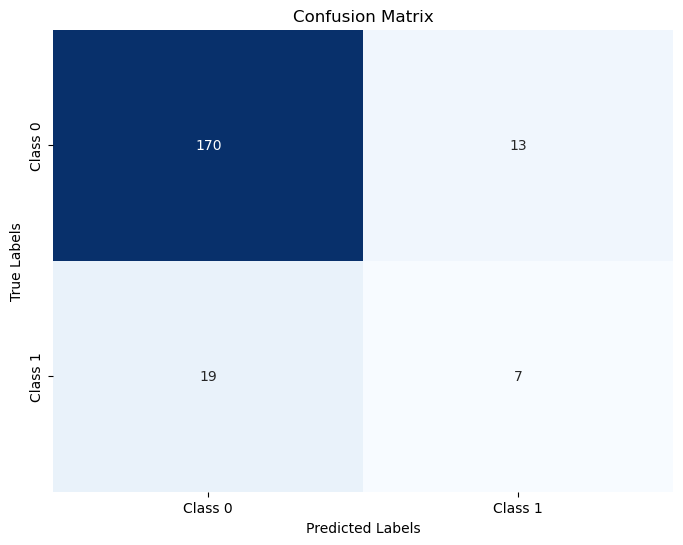

In [44]:
param_grid5d = {
    'min_child_weight': [1, 2, 3, 4, 5],
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
}
best_params5d, best_model5d = grid_searcher(param_grid5d, best_model5c, 'matthews_corrcoef')
model_test(best_model5d)

Fitting 10 folds for each of 375 candidates, totalling 3750 fits
Time taken: 57.34744381904602 seconds
Best Hyperparameters: {'gamma': 0, 'max_delta_step': 0, 'reg_alpha': 0.01, 'scale_pos_weight': 1}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.90      0.95      0.92       183
     Class 1       0.41      0.27      0.33        26

    accuracy                           0.86       209
   macro avg       0.66      0.61      0.62       209
weighted avg       0.84      0.86      0.85       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       173 |        10 |
+-----------+-----------+
|        19 |         7 |
+-----------+-----------+


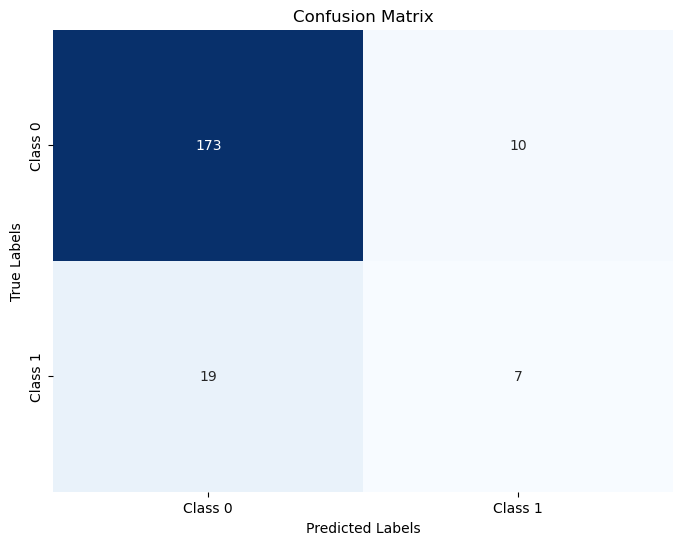

In [45]:
param_grid5e = {
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'reg_alpha': [0.01, 0.1, 1, 10, 100],
    'scale_pos_weight': [1, 2, 3, 4, 5],
    'max_delta_step': [0, 1, 2],
}
best_params5e, best_model5e = grid_searcher(param_grid5e, best_model5d, 'matthews_corrcoef')
model_test(best_model5e)

Fitting 10 folds for each of 99 candidates, totalling 990 fits
Time taken: 26.262486696243286 seconds
Best Hyperparameters: {'reg_alpha': 0.7000000000000001}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.90      0.97      0.93       183
     Class 1       0.54      0.27      0.36        26

    accuracy                           0.88       209
   macro avg       0.72      0.62      0.65       209
weighted avg       0.86      0.88      0.86       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       177 |         6 |
+-----------+-----------+
|        19 |         7 |
+-----------+-----------+


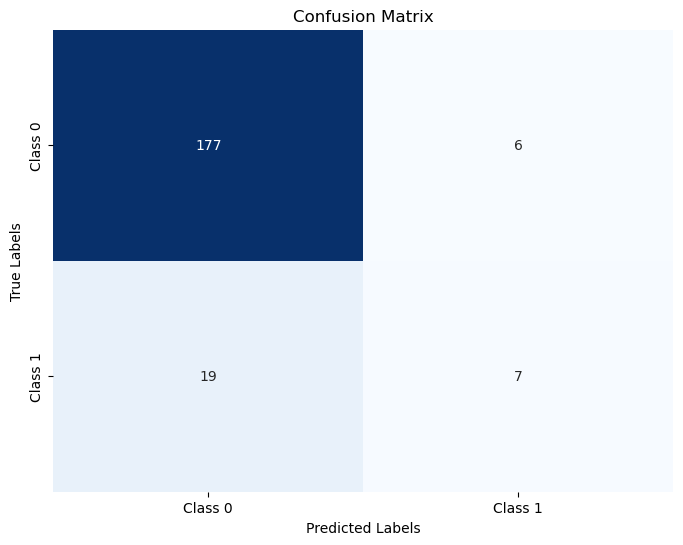

In [46]:
param_grid5f = {
    'reg_alpha': list(np.arange(0.01, 1, 0.01)),
}
best_params5f, best_model5f = grid_searcher(param_grid5f, best_model5e, 'matthews_corrcoef')
model_test(best_model5f)

# AVERAGE_PRECISION

Fitting 10 folds for each of 620 candidates, totalling 6200 fits
Time taken: 202.03948855400085 seconds
Best Hyperparameters: {'max_depth': 3, 'n_estimators': 210, 'reg_lambda': 10}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.90      0.94      0.92       183
     Class 1       0.35      0.23      0.28        26

    accuracy                           0.85       209
   macro avg       0.62      0.59      0.60       209
weighted avg       0.83      0.85      0.84       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       172 |        11 |
+-----------+-----------+
|        20 |         6 |
+-----------+-----------+


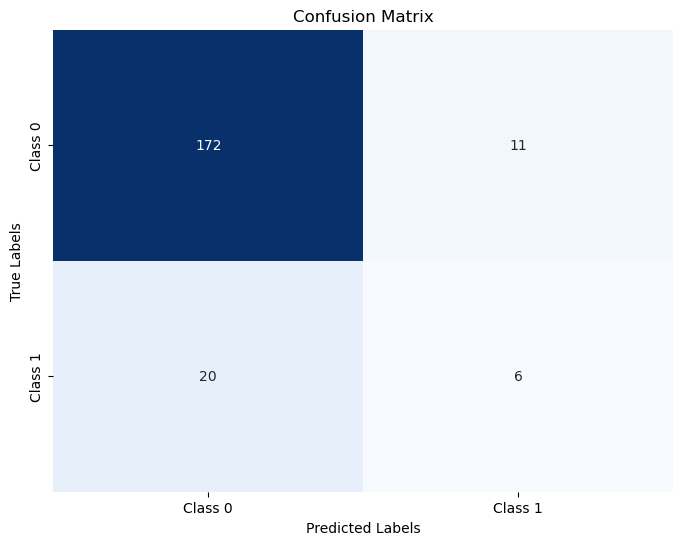

In [48]:
param_grid6a = {
    'n_estimators': list(np.arange(100, 401, 10)),
    'max_depth': [3, 4, 5, 6, 7],
    'reg_lambda': [0.1, 1, 10, 100],
}
best_params6a, best_model6a = grid_searcher(param_grid6a, model1, 'average_precision')
model_test(best_model6a)

Fitting 10 folds for each of 600 candidates, totalling 6000 fits
Time taken: 113.83829736709595 seconds
Best Hyperparameters: {'learning_rate': 1, 'reg_lambda': 93}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.90      0.93      0.92       183
     Class 1       0.40      0.31      0.35        26

    accuracy                           0.86       209
   macro avg       0.65      0.62      0.63       209
weighted avg       0.84      0.86      0.85       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       171 |        12 |
+-----------+-----------+
|        18 |         8 |
+-----------+-----------+


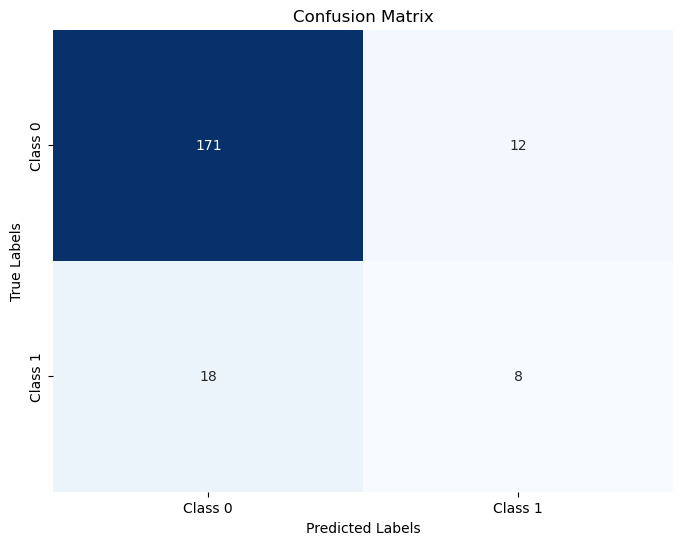

In [49]:
param_grid6b = {
    'reg_lambda': list(np.arange(1, 101)),
    'learning_rate': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]
}
best_params6b, best_model6b = grid_searcher(param_grid6b, best_model6a, 'average_precision')
model_test(best_model6b)

Fitting 10 folds for each of 99 candidates, totalling 990 fits
Time taken: 11.25779414176941 seconds
Best Hyperparameters: {'learning_rate': 0.97}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.91      0.94      0.92       183
     Class 1       0.42      0.31      0.36        26

    accuracy                           0.86       209
   macro avg       0.66      0.62      0.64       209
weighted avg       0.85      0.86      0.85       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       172 |        11 |
+-----------+-----------+
|        18 |         8 |
+-----------+-----------+


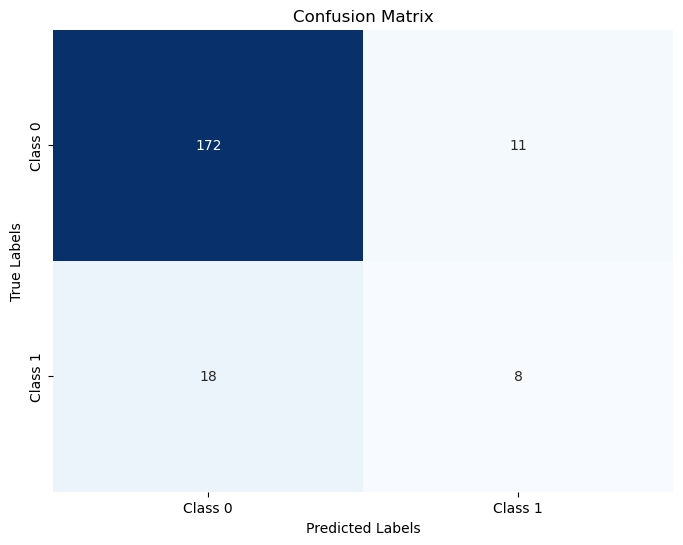

In [50]:
param_grid6c = {
    'learning_rate': list(np.arange(0.01, 1, 0.01))
}
best_params6c, best_model6c = grid_searcher(param_grid6c, best_model6b, 'average_precision')
model_test(best_model6c)

Fitting 10 folds for each of 180 candidates, totalling 1800 fits
Time taken: 17.45933437347412 seconds
Best Hyperparameters: {'colsample_bytree': 0.6, 'min_child_weight': 1, 'subsample': 0.9}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.91      0.95      0.93       183
     Class 1       0.44      0.31      0.36        26

    accuracy                           0.87       209
   macro avg       0.68      0.63      0.64       209
weighted avg       0.85      0.87      0.86       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       173 |        10 |
+-----------+-----------+
|        18 |         8 |
+-----------+-----------+


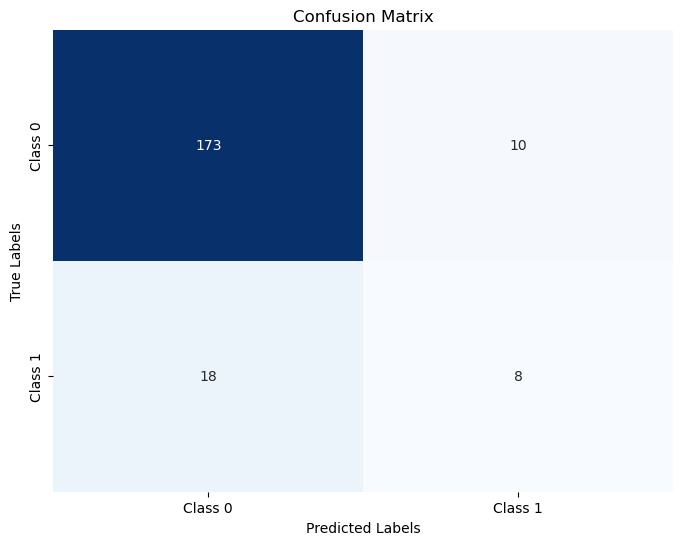

In [51]:
param_grid6d = {
    'min_child_weight': [1, 2, 3, 4, 5],
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
}
best_params6d, best_model6d = grid_searcher(param_grid6d, best_model6c, 'average_precision')
model_test(best_model6d)

Fitting 10 folds for each of 375 candidates, totalling 3750 fits
Time taken: 26.301217794418335 seconds
Best Hyperparameters: {'gamma': 0, 'max_delta_step': 1, 'reg_alpha': 0.01, 'scale_pos_weight': 4}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.92      0.87      0.90       183
     Class 1       0.35      0.50      0.41        26

    accuracy                           0.82       209
   macro avg       0.64      0.68      0.65       209
weighted avg       0.85      0.82      0.84       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       159 |        24 |
+-----------+-----------+
|        13 |        13 |
+-----------+-----------+


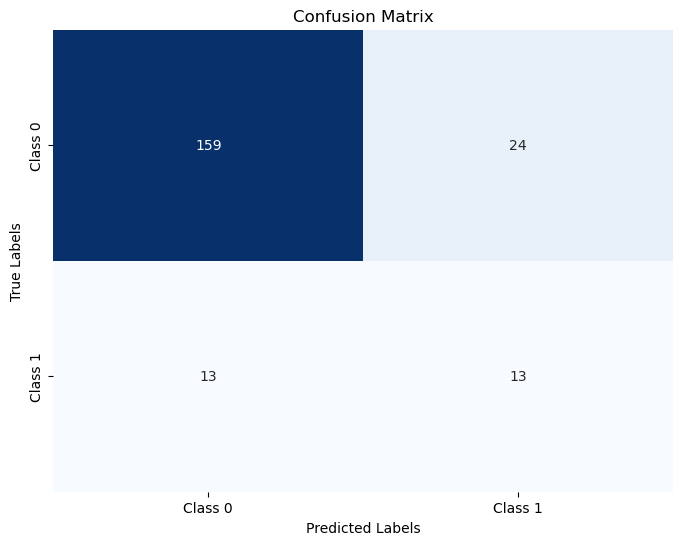

In [52]:
param_grid6e = {
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'reg_alpha': [0.01, 0.1, 1, 10, 100],
    'scale_pos_weight': [1, 2, 3, 4, 5],
    'max_delta_step': [0, 1, 2],
}
best_params6e, best_model6e = grid_searcher(param_grid6e, best_model6d, 'average_precision')
model_test(best_model6e)

Fitting 10 folds for each of 99 candidates, totalling 990 fits
Time taken: 9.512059688568115 seconds
Best Hyperparameters: {'reg_alpha': 0.5700000000000001}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.92      0.85      0.89       183
     Class 1       0.33      0.50      0.39        26

    accuracy                           0.81       209
   macro avg       0.62      0.68      0.64       209
weighted avg       0.85      0.81      0.83       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       156 |        27 |
+-----------+-----------+
|        13 |        13 |
+-----------+-----------+


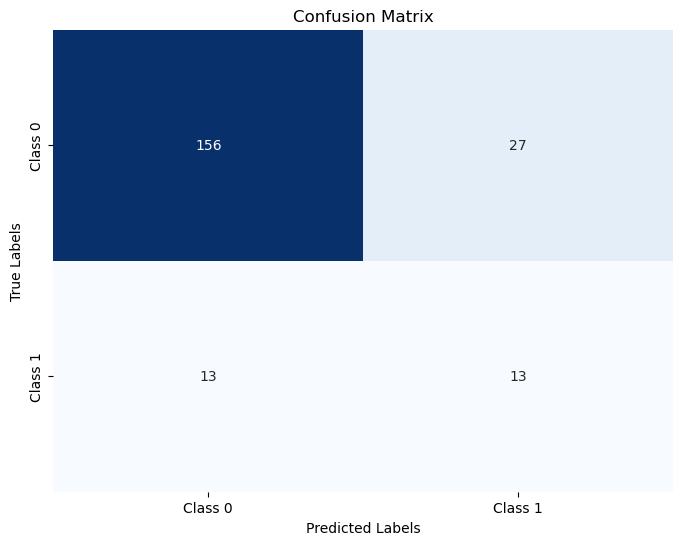

In [53]:
param_grid6f = {
    'reg_alpha': list(np.arange(0.01, 1, 0.01)),
}
best_params6f, best_model6f = grid_searcher(param_grid6f, best_model6e, 'average_precision')
model_test(best_model6f)

# BALANCED_ACCURACY

Fitting 10 folds for each of 620 candidates, totalling 6200 fits
Time taken: 137.88285064697266 seconds
Best Hyperparameters: {'max_depth': 7, 'n_estimators': 310, 'reg_lambda': 1}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.89      0.96      0.92       183
     Class 1       0.38      0.19      0.26        26

    accuracy                           0.86       209
   macro avg       0.64      0.57      0.59       209
weighted avg       0.83      0.86      0.84       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       175 |         8 |
+-----------+-----------+
|        21 |         5 |
+-----------+-----------+


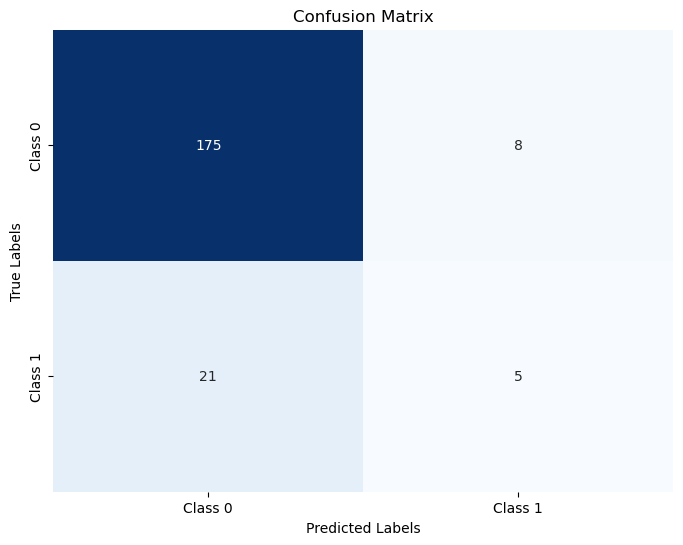

In [54]:
param_grid7a = {
    'n_estimators': list(np.arange(100, 401, 10)),
    'max_depth': [3, 4, 5, 6, 7],
    'reg_lambda': [0.1, 1, 10, 100],
}
best_params7a, best_model7a = grid_searcher(param_grid7a, model1, 'balanced_accuracy')
model_test(best_model7a)

Fitting 10 folds for each of 5 candidates, totalling 50 fits
Time taken: 1.4599533081054688 seconds
Best Hyperparameters: {'max_depth': 7}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.89      0.96      0.92       183
     Class 1       0.38      0.19      0.26        26

    accuracy                           0.86       209
   macro avg       0.64      0.57      0.59       209
weighted avg       0.83      0.86      0.84       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       175 |         8 |
+-----------+-----------+
|        21 |         5 |
+-----------+-----------+


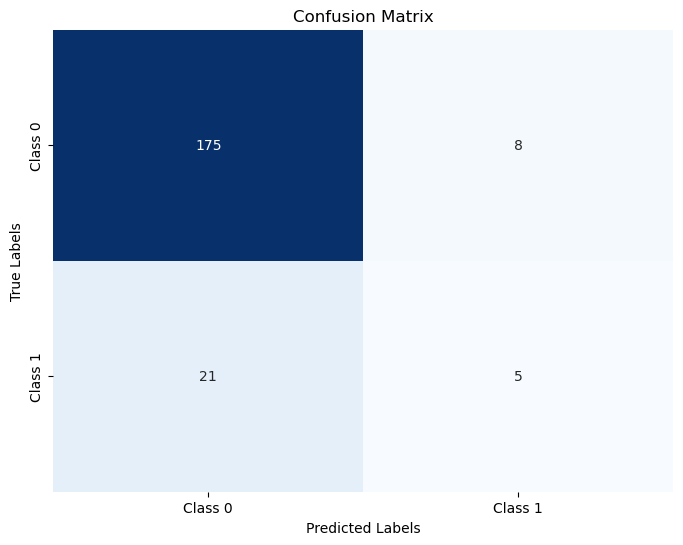

In [55]:
param_grid7ai = {
    'max_depth': [5, 6, 7, 8, 9],
}
best_params7ai, best_model7ai = grid_searcher(param_grid7ai, best_model7a, 'balanced_accuracy')
model_test(best_model7ai)

Fitting 10 folds for each of 594 candidates, totalling 5940 fits
Time taken: 285.6921443939209 seconds
Best Hyperparameters: {'learning_rate': 1, 'reg_lambda': 1.2000000000000002}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.89      0.95      0.92       183
     Class 1       0.36      0.19      0.25        26

    accuracy                           0.86       209
   macro avg       0.62      0.57      0.59       209
weighted avg       0.83      0.86      0.84       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       174 |         9 |
+-----------+-----------+
|        21 |         5 |
+-----------+-----------+


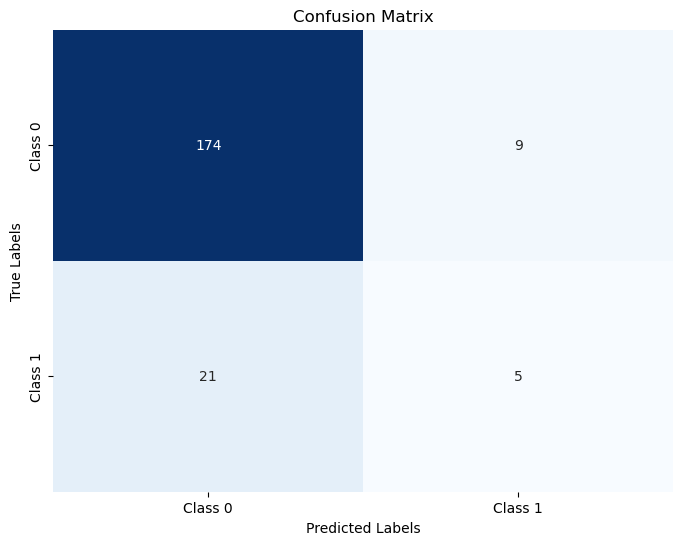

In [56]:
param_grid7b = {
    'reg_lambda': list(np.arange(0.1, 10, 0.1)),
    'learning_rate': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]
}
best_params7b, best_model7b = grid_searcher(param_grid7b, best_model7a, 'balanced_accuracy')
model_test(best_model7b)

Fitting 10 folds for each of 99 candidates, totalling 990 fits
Time taken: 21.791836500167847 seconds
Best Hyperparameters: {'learning_rate': 0.64}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.90      0.95      0.92       183
     Class 1       0.41      0.27      0.33        26

    accuracy                           0.86       209
   macro avg       0.66      0.61      0.62       209
weighted avg       0.84      0.86      0.85       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       173 |        10 |
+-----------+-----------+
|        19 |         7 |
+-----------+-----------+


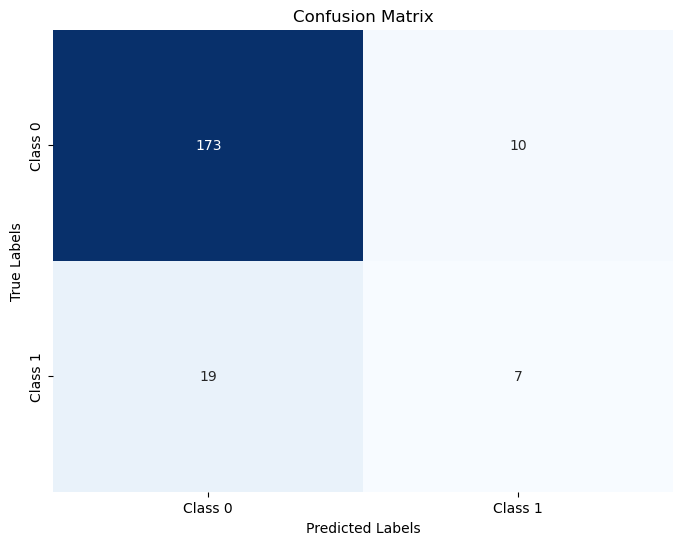

In [57]:
param_grid7c = {
    'learning_rate': list(np.arange(1e-2, 1, 1e-2))
}
best_params7c, best_model7c = grid_searcher(param_grid7c, best_model7b, 'balanced_accuracy')
model_test(best_model7c)

Fitting 10 folds for each of 180 candidates, totalling 1800 fits
Time taken: 22.185213804244995 seconds
Best Hyperparameters: {'colsample_bytree': 1.0, 'min_child_weight': 1, 'subsample': 1.0}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.90      0.95      0.92       183
     Class 1       0.41      0.27      0.33        26

    accuracy                           0.86       209
   macro avg       0.66      0.61      0.62       209
weighted avg       0.84      0.86      0.85       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       173 |        10 |
+-----------+-----------+
|        19 |         7 |
+-----------+-----------+


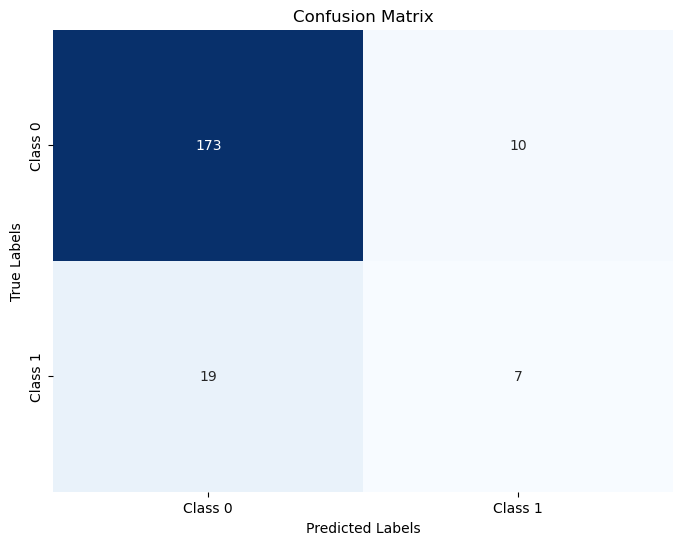

In [58]:
param_grid7d = {
    'min_child_weight': [1, 2, 3, 4, 5],
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
}
best_params7d, best_model7d = grid_searcher(param_grid7d, best_model7c, 'balanced_accuracy')
model_test(best_model7d)

Fitting 10 folds for each of 375 candidates, totalling 3750 fits
Time taken: 31.1636483669281 seconds
Best Hyperparameters: {'gamma': 0.2, 'max_delta_step': 0, 'reg_alpha': 0.1, 'scale_pos_weight': 1}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.90      0.95      0.92       183
     Class 1       0.41      0.27      0.33        26

    accuracy                           0.86       209
   macro avg       0.66      0.61      0.62       209
weighted avg       0.84      0.86      0.85       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       173 |        10 |
+-----------+-----------+
|        19 |         7 |
+-----------+-----------+


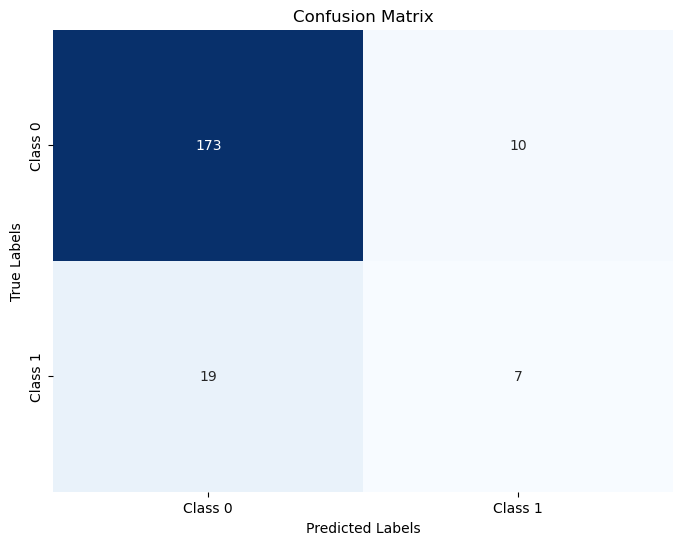

In [59]:
param_grid7e = {
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'reg_alpha': [0.01, 0.1, 1, 10, 100],
    'scale_pos_weight': [1, 2, 3, 4, 5],
    'max_delta_step': [0, 1, 2],
}
best_params7e, best_model7e = grid_searcher(param_grid7e, best_model7d, 'balanced_accuracy')
model_test(best_model7e)

Fitting 10 folds for each of 99 candidates, totalling 990 fits
Time taken: 7.651098251342773 seconds
Best Hyperparameters: {'reg_alpha': 0.09999999999999999}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.90      0.95      0.92       183
     Class 1       0.41      0.27      0.33        26

    accuracy                           0.86       209
   macro avg       0.66      0.61      0.62       209
weighted avg       0.84      0.86      0.85       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       173 |        10 |
+-----------+-----------+
|        19 |         7 |
+-----------+-----------+


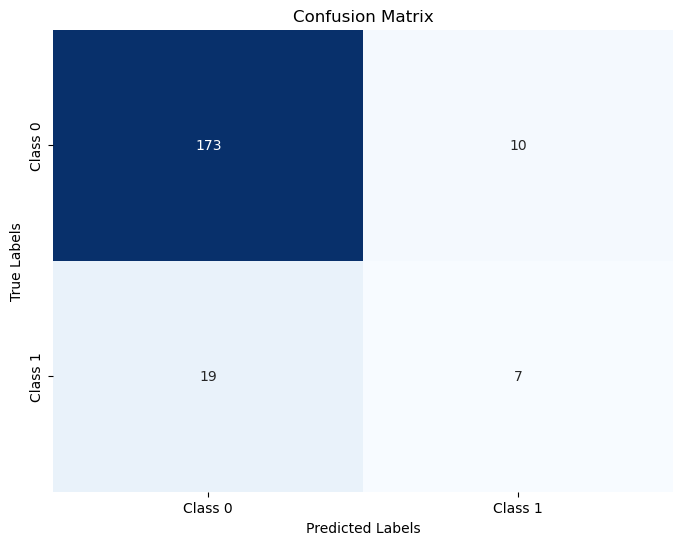

In [60]:
param_grid7f = {
    'reg_alpha': list(np.arange(0.01, 1, 0.01)),
}
best_params7f, best_model7f = grid_searcher(param_grid7f, best_model7e, 'balanced_accuracy')
model_test(best_model7f)

# JACCARD

Fitting 10 folds for each of 620 candidates, totalling 6200 fits
Time taken: 126.59044623374939 seconds
Best Hyperparameters: {'max_depth': 7, 'n_estimators': 310, 'reg_lambda': 1}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.89      0.96      0.92       183
     Class 1       0.38      0.19      0.26        26

    accuracy                           0.86       209
   macro avg       0.64      0.57      0.59       209
weighted avg       0.83      0.86      0.84       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       175 |         8 |
+-----------+-----------+
|        21 |         5 |
+-----------+-----------+


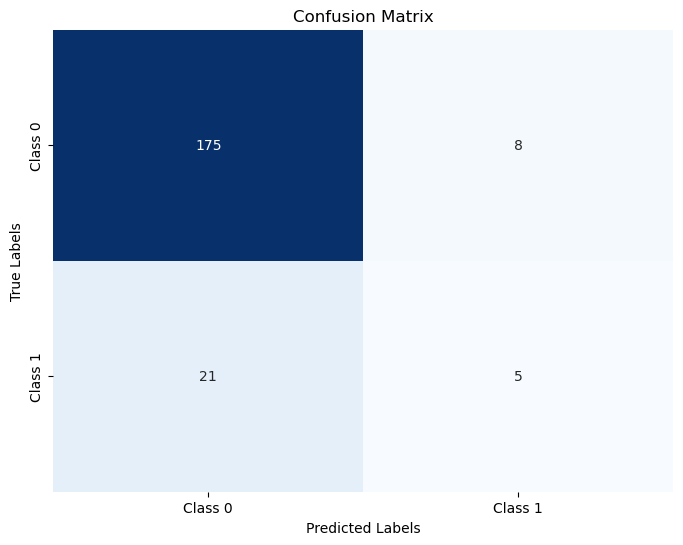

In [61]:
param_grid8a = {
    'n_estimators': list(np.arange(100, 401, 10)),
    'max_depth': [3, 4, 5, 6, 7],
    'reg_lambda': [0.1, 1, 10, 100],
}
best_params8a, best_model8a = grid_searcher(param_grid8a, model1, 'jaccard')
model_test(best_model8a)

Fitting 10 folds for each of 594 candidates, totalling 5940 fits
Time taken: 282.38438081741333 seconds
Best Hyperparameters: {'learning_rate': 1, 'reg_lambda': 1.2000000000000002}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.89      0.95      0.92       183
     Class 1       0.36      0.19      0.25        26

    accuracy                           0.86       209
   macro avg       0.62      0.57      0.59       209
weighted avg       0.83      0.86      0.84       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       174 |         9 |
+-----------+-----------+
|        21 |         5 |
+-----------+-----------+


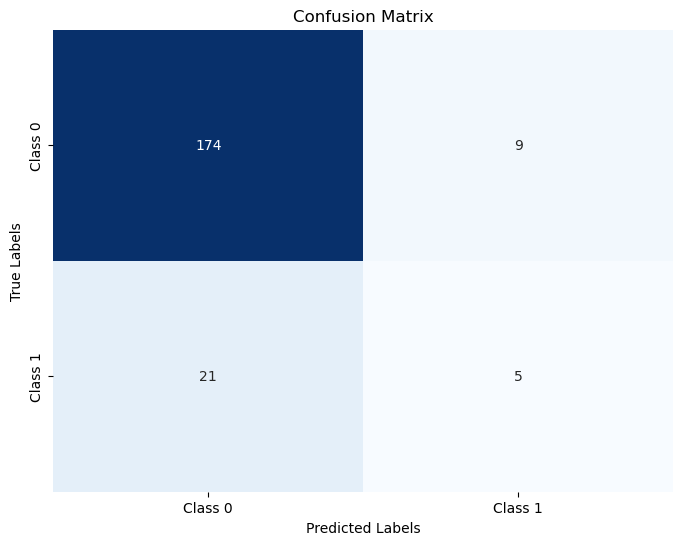

In [62]:
param_grid8b = {
    'reg_lambda': list(np.arange(0.1, 10, 0.1)),
    'learning_rate': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]
}
best_params8b, best_model8b = grid_searcher(param_grid8b, best_model8a, 'jaccard')
model_test(best_model8b)

Fitting 10 folds for each of 99 candidates, totalling 990 fits
Time taken: 22.480353593826294 seconds
Best Hyperparameters: {'learning_rate': 0.64}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.90      0.95      0.92       183
     Class 1       0.41      0.27      0.33        26

    accuracy                           0.86       209
   macro avg       0.66      0.61      0.62       209
weighted avg       0.84      0.86      0.85       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       173 |        10 |
+-----------+-----------+
|        19 |         7 |
+-----------+-----------+


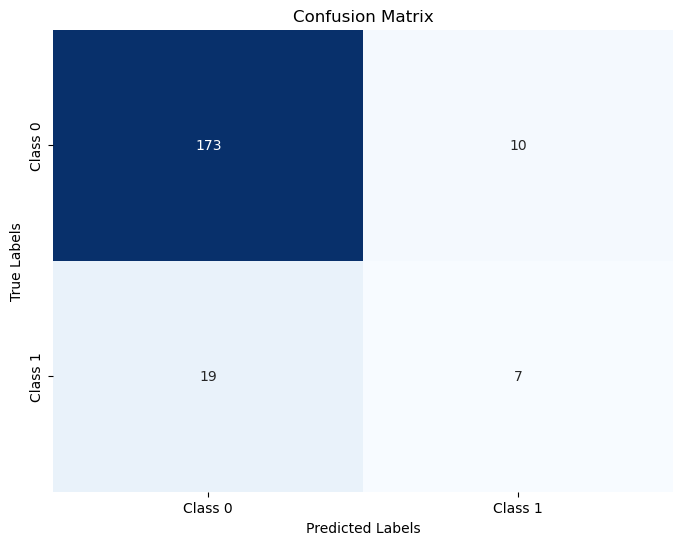

In [63]:
param_grid8c = {
    'learning_rate': list(np.arange(1e-2, 1, 1e-2))
}
best_params8c, best_model8c = grid_searcher(param_grid8c, best_model8b, 'jaccard')
model_test(best_model8c)

Fitting 10 folds for each of 180 candidates, totalling 1800 fits
Time taken: 22.767684936523438 seconds
Best Hyperparameters: {'colsample_bytree': 1.0, 'min_child_weight': 1, 'subsample': 1.0}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.90      0.95      0.92       183
     Class 1       0.41      0.27      0.33        26

    accuracy                           0.86       209
   macro avg       0.66      0.61      0.62       209
weighted avg       0.84      0.86      0.85       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       173 |        10 |
+-----------+-----------+
|        19 |         7 |
+-----------+-----------+


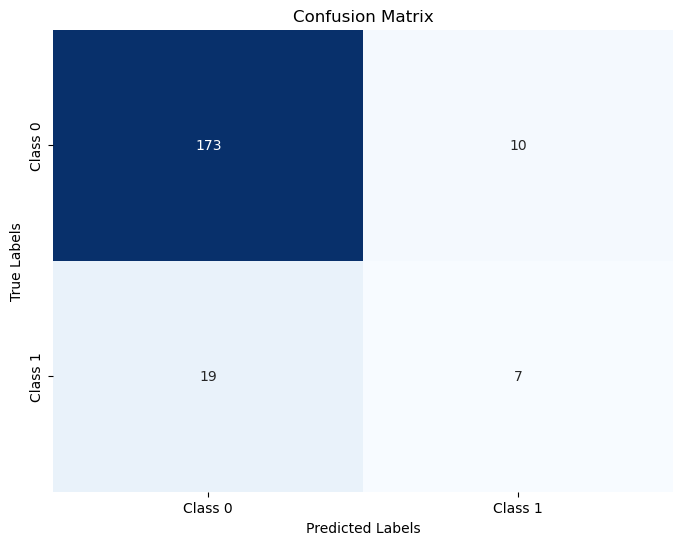

In [64]:
param_grid8d = {
    'min_child_weight': [1, 2, 3, 4, 5],
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
}
best_params8d, best_model8d = grid_searcher(param_grid8d, best_model8c, 'jaccard')
model_test(best_model8d)

Fitting 10 folds for each of 375 candidates, totalling 3750 fits
Time taken: 35.032012701034546 seconds
Best Hyperparameters: {'gamma': 0.2, 'max_delta_step': 0, 'reg_alpha': 0.1, 'scale_pos_weight': 1}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.90      0.95      0.92       183
     Class 1       0.41      0.27      0.33        26

    accuracy                           0.86       209
   macro avg       0.66      0.61      0.62       209
weighted avg       0.84      0.86      0.85       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       173 |        10 |
+-----------+-----------+
|        19 |         7 |
+-----------+-----------+


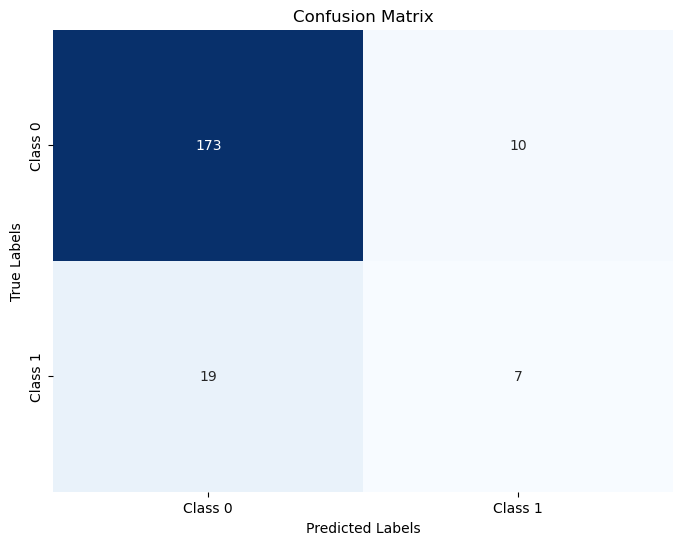

In [65]:
param_grid8e = {
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'reg_alpha': [0.01, 0.1, 1, 10, 100],
    'scale_pos_weight': [1, 2, 3, 4, 5],
    'max_delta_step': [0, 1, 2],
}
best_params8e, best_model8e = grid_searcher(param_grid8e, best_model8d, 'jaccard')
model_test(best_model8e)

Fitting 10 folds for each of 99 candidates, totalling 990 fits
Time taken: 27.605416536331177 seconds
Best Hyperparameters: {'reg_alpha': 0.09999999999999999}
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.90      0.95      0.92       183
     Class 1       0.41      0.27      0.33        26

    accuracy                           0.86       209
   macro avg       0.66      0.61      0.62       209
weighted avg       0.84      0.86      0.85       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       173 |        10 |
+-----------+-----------+
|        19 |         7 |
+-----------+-----------+


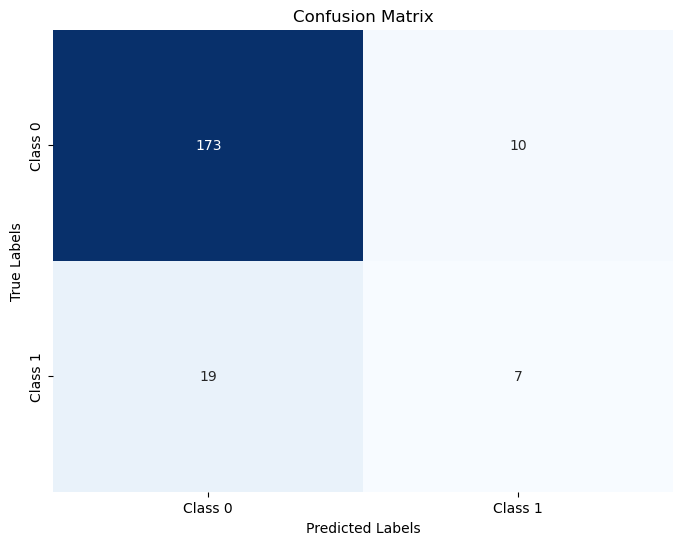

In [66]:
param_grid8f = {
    'reg_alpha': list(np.arange(0.01, 1, 0.01))
}
best_params8f, best_model8f = grid_searcher(param_grid8f, best_model8e, 'jaccard')
model_test(best_model8f)